**20164245 Hong Jin**

# Load MNIST traning dataset.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

file_data		= "mnist_train.csv"
handle_file	= open(file_data, "r")
data        		= handle_file.readlines()
handle_file.close()

test_file_data = "mnist_test.csv"
handle_test_file = open(test_file_data,"r")
test_data = handle_test_file.readlines()
handle_test_file.close()

size_row	= 28    # height of the image
size_col  	= 28    # width of the image
dim = size_col * size_row

num_image	= len(data)
test_num_image = len(test_data)

E = []
A = []
tA = []

# Nomarlization

In [2]:
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

# Make label, image array with train data

In [3]:
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)
count = 0

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector    

    count += 1

# Make label, image array with test data

In [4]:
test_list_image  = np.empty((size_row * size_col, test_num_image), dtype=float)
test_list_label  = np.empty(test_num_image, dtype=int)
test_count = 0

for test_line in test_data:

    test_line_data   = test_line.split(',')
    test_label       = test_line_data[0]
    test_im_vector   = np.asfarray(test_line_data[1:])
    test_im_vector   = normalize(test_im_vector)

    test_list_label[test_count]       = test_label
    test_list_image[:, test_count]    = test_im_vector    

    test_count += 1

# Compute distance based on L2-norm (x, (0,0))

$$||x-y||_{2} = \sqrt{x^2 + y^2} $$

In [5]:
def distance(x,y):
    d = (x - y) ** 2
    s = np.sum(d)
    r = np.sqrt(s)
    
    return r

# Initialize Label

initialize all images with random label

In [6]:
def initialLabel(list_image, cluster_num):
    cluster_label = np.zeros(num_image, dtype=int)
    for i in range(num_image):
        initial_num = np.random.randint(0, cluster_num)
        cluster_label[i] = initial_num
        
    return cluster_label

# Initialize Centroid

In [7]:
def initialCentroid(list_image, cluster_num, cluster_label, im_average, im_count):

    for i in range(num_image):
        im_average[:,cluster_label[i]] += list_image[:,i]
        im_count[cluster_label[i]] += 1
    
    return im_average, im_count

# Plot the Average Image

In [8]:
def plot_average(im_average, im_count, cluster_num):
    f1 = plt.figure(1)
    
    for i in range(cluster_num) :
        im_average[:,i] /= im_count[i]
        im_L2matrix = im_average[:,i].reshape((size_row,size_col))
    
        plt.subplot(cluster_num/5 ,5,i+1)
        plt.title("C" + str(i) )
        plt.imshow(im_L2matrix, cmap='Greys', interpolation = 'None')
    
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)

    plt.show()

    return im_average

# Clustering

In [9]:
def clustering(list_image, num_image, cluster_label, cluster_num, im_average):
    cluster_element = []
    
    for i in range(cluster_num):
        cluster_element.append([])

    for i in range(num_image):
        dist = []
        for j in range(cluster_num):
            x = list_image[:, i]
            y = im_average[:, j]
            dist.append(distance(x, y))
        cluster_label[i] = np.argmin(dist)
        cluster_element[cluster_label[i]].append(i)
    
    return cluster_element, cluster_label

# Compute Centroid

$$C_{A} = \frac{1}{n_{A}}\Sigma x_{i}$$

In [10]:
def computeCentroid(cluster_num, cluster_label):
    num = np.zeros((cluster_num))
    c = np.zeros((size_row*size_col, cluster_num))
    
    for i in range(num_image):
        c[:,cluster_label[i]] += list_image[:,i]
        num[cluster_label[i]] += 1 
    
    for i in range(cluster_num):
        c[:,i] /= num[i]
    
    return c

# Compute Engergy

$$E = \frac{1}{N}\Sigma || x_{i} - c_{k} ||^2$$

In [11]:
def computeEnergy(cluster_label, cluster_num, im_average, num_image, list_image):
    total_sum = 0
    for i in range(num_image):
        total_sum += sum((im_average[:,cluster_label[i]]- list_image[:,i]) ** 2)
    
    total = total_sum / num_image
    
    return total

# Compute Accuracy

$$ A = \frac{1}{N}\Sigma count(x_{i}, c_{k})$$

In [12]:
def computeAccuracy(cluster_elements, cluster_label, cluster_num, list_label, num_image):
    total = 0
    a = np.zeros(cluster_num,dtype = int)
    
    for i in range(cluster_num):
        in_label = np.zeros(10, dtype = int)
        for j in range(len(cluster_elements[i])):
            in_label[list_label[cluster_elements[i][j]]] += 1
        
        a[i] = np.argmax(in_label)
        total += in_label[a[i]]

    total /= num_image
    return total

# Initialize Cluster

In [13]:
def initialCluster(cluster_num):
    im_average  = np.zeros((size_row * size_col, cluster_num), dtype=float)
    im_count = np.zeros(cluster_num, dtype=int)

    cluster_label = initialLabel(list_image, cluster_num)

    im_average, im_count = initialCentroid(list_image, cluster_num, cluster_label,im_average, im_count)
    im_average = plot_average(im_average, im_count, cluster_num)
    
    E.clear()
    A.clear()
    tA.clear()
    
    return im_average, im_count, cluster_label

# Clustering until no change

In [19]:
def iteration(cluster_num, im_average, im_count, cluster_label):
    iter_num = 0
    while True:
        cluster_element, cluster_label = clustering(list_image, num_image, cluster_label, cluster_num, im_average)
        t_cluster_element, t_cluster_label = clustering(test_list_image, test_num_image, cluster_label, cluster_num, im_average)
        
        im_average = computeCentroid(cluster_num, cluster_label)
        E.append(computeEnergy(cluster_label, cluster_num, im_average,num_image, list_image))
        A.append(computeAccuracy(cluster_element, cluster_label, cluster_num, list_label, num_image))
        tA.append(computeAccuracy(t_cluster_element, t_cluster_label, cluster_num, test_list_label, test_num_image))
    
        
        if iter_num >= 1 :
            print(E[iter_num-1] - E[iter_num])
            if E[iter_num -1] - E[iter_num] < 0.0005:
                break
        iter_num += 1

    plot_average(im_average, im_count, cluster_num)
    return iter_num

# Energy graph per each iteration

In [15]:
def drawEnergy(iter_num):
    plt.figure(3)
    x_range = np.arange(iter_num+1)
    plt.plot(x_range, E, "g")
    plt.title("Energy")
    plt.grid(True)
    plt.show()

# Accuracy graph per each iteration

In [16]:
def drawAccuracy(iter_num, A,name):
    plt.figure(4)
    x_range = np.arange(iter_num+1)
    plt.plot(x_range, A, "r")
    plt.title("accuracy - " + str(name))
    plt.grid(True)
    plt.show()

# K = 5

## Initial average image

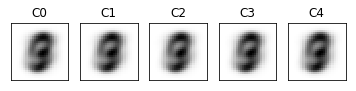

In [20]:
im_average, im_count, cluster_label = initialCluster(5)

## Final average image

In [21]:
iter_num = iteration(5,im_average, im_count, cluster_label)

1.145558398904278
0.2464158774118772
0.1252792581936646
0.13602943871838846
0.14964232602109462
0.1164372752277032
0.07176517931201687
0.03153130377040014
0.021787026646357788
0.01828603846805521
0.012694321722428015
0.002587252274985019


KeyboardInterrupt: 

## Energy, Accuracy graphs

In [ ]:
drawEnergy(iter_num)
drawAccuracy(iter_num,A,"train")
drawAccuracy(iter_num,tA,"test")

# K = 10

## Initial average image

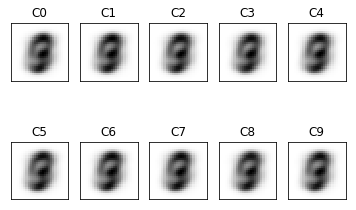

In [23]:
im_average, im_count, cluster_label = initialCluster(10)

## Final average image

In [24]:
iter_num = iteration(10,im_average, im_count, cluster_label)

KeyboardInterrupt: 

## Energy, Accuracy graphs

In [ ]:
drawEnergy(iter_num)
drawAccuracy(iter_num,A,"train")
drawAccuracy(iter_num,tA,"test")

# K = 15

## Initial average image

In [ ]:
im_average, im_count, cluster_label = initialCluster(15)

## Final average image

In [ ]:
iter_num = iteration(15,im_average, im_count, cluster_label)

## Energy, Accuracy graphs

In [ ]:
drawEnergy(iter_num)
drawAccuracy(iter_num,A,"train")
drawAccuracy(iter_num,tA,"test")

# K = 20

## Initial average image

In [ ]:
im_average, im_count, cluster_label = initialCluster(20)

## Final average image

In [ ]:
iter_num = iteration(20,im_average, im_count, cluster_label)

## Energy, Accuracy graphs

In [ ]:
drawEnergy(iter_num)
drawAccuracy(iter_num,A,"train")
drawAccuracy(iter_num,tA,"test")